# Data Collection

In [277]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd

os.chdir(".")
res1 = [i for i in glob.glob("results/MAP_dataset=*[!fixed_prior]")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
MAP = pd.concat(df)


res1 = [i for i in glob.glob("results/LLA_dataset=*[!fixed_prior]")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
LLA = pd.concat(df)


res1 = [i for i in glob.glob("results/ELLA_dataset=*[!fixed_prior]")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
ELLA = pd.concat(df)


In [278]:

min_value = ELLA.groupby(["M", "dataset", "seed"])["val_NLL"].min()
ELLA_min = ELLA.merge(min_value, on=["M", "dataset", "seed"], suffixes=('', '_min'))
ELLA_min = ELLA_min.query("val_NLL == val_NLL_min")
#print(indices_min_nll)
#ELLA_max = ELLA.loc[indices_min_nll]
ELLA_min = ELLA_min.groupby(["M", "dataset", "seed"]).first().reset_index()
ELLA_min = ELLA_min.drop("val_NLL_min", axis = 1)

In [279]:


res1 = [i for i in glob.glob("results/VaLLA_dataset*[!fixed_prior]")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
VaLLA = pd.concat(df)


def std(x):
    return np.std(x) / np.sqrt(len(x))


VaLLA["model"] = "VaLLA"
MAP["model"] = "MAP"
ELLA_min["model"] = "ELLA"
LLA["model"] = "LLA"

df = pd.concat([MAP, LLA, ELLA_min, VaLLA]).drop(
    ["LOSS", "Unnamed: 0", "iterations", "weight_decay", "MAP_iterations"], axis=1
)


In [280]:
regression = df[df["dataset"].isin(["Year", "Airline", "Taxi"])]
multiclass = df[~df["dataset"].isin(["Year", "Airline", "Taxi"])]
regression = regression.dropna(axis = 1, how = 'all')
multiclass = multiclass.dropna(axis = 1, how = 'all')

In [281]:
Q = np.array([np.zeros_like(np.abs(regression["Q-10"]-0.1)), 
              np.abs(regression["Q-10"]-0.1).to_numpy(), 
              np.abs(regression["Q-20"]-0.2).to_numpy(), 
              np.abs(regression["Q-30"]-0.3).to_numpy(), 
              np.abs(regression["Q-40"]-0.4).to_numpy(), 
              np.abs(regression["Q-50"]-0.5).to_numpy(), 
              np.abs(regression["Q-60"]-0.6).to_numpy(), 
              np.abs(regression["Q-70"]-0.7).to_numpy(), 
              np.abs(regression["Q-80"]-0.8).to_numpy(), 
              np.abs(regression["Q-90"]-0.9).to_numpy(),
              np.ones_like(np.abs(regression["Q-10"]-0.1))
              ]).T

In [282]:
import scipy as sp
Q = sp.integrate.trapezoid(x = np.arange(0, 1.1, 0.1), y= Q, axis = 1)
regression["Q"] = Q

In [283]:

# df = df.astype({"M": "int"})
regression = regression.groupby(["dataset", "model","M", "subset", "hessian"], dropna=False).agg(["mean", std])
regression = regression.drop(["seed", "val_NLL", "log_variance", "alpha", "prior_std"], axis = 1)
regression = regression.drop(("RMSE", "std"),axis = 1)
regression = regression.dropna(axis = 1, how = 'all')

In [284]:
multiclass = multiclass.groupby(["dataset", "model","M", "subset", "hessian", "alpha"], dropna=False).agg(["mean", std])
multiclass = multiclass.drop(["seed", "val_NLL", "prior_std"], axis = 1)
multiclass = multiclass.dropna(axis = 1, how = 'all')

# Regression Fully Connected 200-200-200

## Trainable / Validated Prior

#### Airline

In [285]:
subset =  [("RMSE", "mean"), ("NLL", "mean"),
           ("Q", "mean"),
           ("CRPS", "mean"), ("time", "mean")]

Q_columns = ["Q-10", "Q-20", "Q-30", "Q-40", "Q-50", "Q-60", "Q-70", "Q-80", "Q-90"]
regression.query("dataset == 'Airline'").drop(Q_columns, axis = 1).reset_index().style.background_gradient(axis=0, subset = subset) 

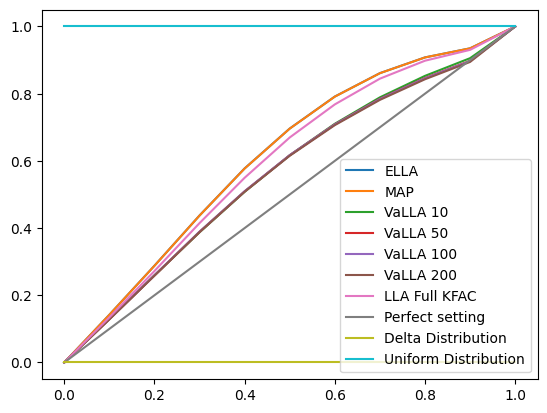

In [294]:
import matplotlib.pyplot as plt

columns = [
    ("Q-10", "mean"), ("Q-20", "mean"),("Q-30", "mean"),("Q-40", "mean"),("Q-50", "mean"),("Q-60", "mean"),
    ("Q-70", "mean"),("Q-80", "mean"),("Q-90", "mean"),
    ]

x = np.arange(0., 1.1, 0.1)
plt.plot(x, [0, *regression.query("dataset == 'Airline' and model == 'ELLA'").reset_index()[columns].to_numpy().flatten(), 1],
         label = "ELLA")
plt.plot(x, [0, *regression.query("dataset == 'Airline' and model == 'MAP'").reset_index()[columns].to_numpy().flatten(), 1],
         label = "MAP")
plt.plot(x, [0, *regression.query("dataset == 'Airline' and model == 'VaLLA' and M == 10").reset_index()[columns].to_numpy().flatten(), 1],
         label = "VaLLA 10")
plt.plot(x, [0, *regression.query("dataset == 'Airline' and model == 'VaLLA' and M == 50").reset_index()[columns].to_numpy().flatten(), 1],
         label = "VaLLA 50")
plt.plot(x, [0, *regression.query("dataset == 'Airline' and model == 'VaLLA' and M == 100").reset_index()[columns].to_numpy().flatten(), 1],
         label = "VaLLA 100")
plt.plot(x, [0, *regression.query("dataset == 'Airline' and model == 'VaLLA' and M == 200").reset_index()[columns].to_numpy().flatten(), 1],
         label = "VaLLA 200")
plt.plot(x, [0, *regression.query("dataset == 'Airline' and model == 'LLA' and hessian == 'kron' and subset == 'all'").reset_index()[columns].to_numpy().flatten(), 1],
         label = "LLA Full KFAC")
plt.plot(x, x, label = "Perfect setting")
plt.plot(x, np.zeros_like(x), label = "Delta Distribution")
plt.plot(x, np.ones_like(x), label = "Uniform Distribution")

plt.legend()
plt.show()

### Year

In [287]:
regression.query("dataset == 'Year'").drop(Q_columns, axis = 1).reset_index().style.background_gradient(axis=0, subset = subset) 

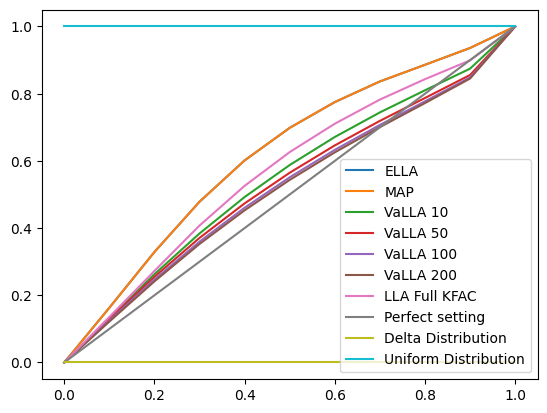

In [295]:
plt.plot(x, [0, *regression.query("dataset == 'Year' and model == 'ELLA'").reset_index()[columns].to_numpy().flatten(), 1],
         label = "ELLA")
plt.plot(x, [0, *regression.query("dataset == 'Year' and model == 'MAP'").reset_index()[columns].to_numpy().flatten(), 1],
         label = "MAP")
plt.plot(x, [0, *regression.query("dataset == 'Year' and model == 'VaLLA' and M == 10").reset_index()[columns].to_numpy().flatten(), 1],
         label = "VaLLA 10")
plt.plot(x, [0, *regression.query("dataset == 'Year' and model == 'VaLLA' and M == 50").reset_index()[columns].to_numpy().flatten(), 1],
         label = "VaLLA 50")
plt.plot(x, [0, *regression.query("dataset == 'Year' and model == 'VaLLA' and M == 100").reset_index()[columns].to_numpy().flatten(), 1],
         label = "VaLLA 100")
plt.plot(x, [0, *regression.query("dataset == 'Year' and model == 'VaLLA' and M == 200").reset_index()[columns].to_numpy().flatten(), 1],
         label = "VaLLA 200")
plt.plot(x, [0, *regression.query("dataset == 'Year' and model == 'LLA' and hessian == 'kron' and subset == 'all'").reset_index()[columns].to_numpy().flatten(), 1],
         label = "LLA Full KFAC")

plt.plot(x, x, label = "Perfect setting")
plt.plot(x, np.zeros_like(x), label = "Delta Distribution")
plt.plot(x, np.ones_like(x), label = "Uniform Distribution")

plt.legend()
plt.show()

### Taxi

In [289]:
regression.query("dataset == 'Taxi'").drop(Q_columns, axis = 1).reset_index().style.background_gradient(axis=0, subset = subset) 

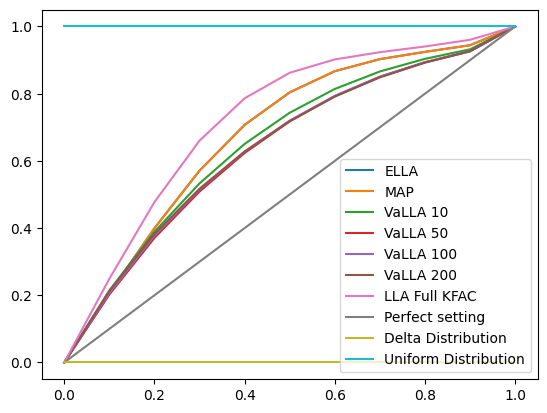

In [296]:
plt.plot(x, [0, *regression.query("dataset == 'Taxi' and model == 'ELLA' and M == 2000").reset_index()[columns].to_numpy().flatten(), 1],
         label = "ELLA")

plt.plot(x, [0, *regression.query("dataset == 'Taxi' and model == 'MAP'").reset_index()[columns].to_numpy().flatten(), 1],
         label = "MAP")
plt.plot(x, [0, *regression.query("dataset == 'Taxi' and model == 'VaLLA' and M == 10").reset_index()[columns].to_numpy().flatten(), 1],
         label = "VaLLA 10")
plt.plot(x, [0, *regression.query("dataset == 'Taxi' and model == 'VaLLA' and M == 50").reset_index()[columns].to_numpy().flatten(), 1],
         label = "VaLLA 50")
plt.plot(x, [0, *regression.query("dataset == 'Taxi' and model == 'VaLLA' and M == 100").reset_index()[columns].to_numpy().flatten(), 1],
         label = "VaLLA 100")
plt.plot(x, [0, *regression.query("dataset == 'Taxi' and model == 'VaLLA' and M == 200").reset_index()[columns].to_numpy().flatten(), 1],
         label = "VaLLA 200")
plt.plot(x, [0, *regression.query("dataset == 'Taxi' and model == 'LLA' and hessian == 'kron' and subset == 'all'").reset_index()[columns].to_numpy().flatten(), 1],
         label = "LLA Full KFAC")

plt.plot(x, x, label = "Perfect setting")
plt.plot(x, np.zeros_like(x), label = "Delta Distribution")
plt.plot(x, np.ones_like(x), label = "Uniform Distribution")
plt.legend()
plt.show()

# Classification Fully-Connected 200-200

### Trainable/Validated Prior

#### CIFAR 10

In [315]:
def plot_corruptions(dataset, metric, c_values, axis):
    q = multiclass.query("dataset == '{}'".format(dataset))[[(metric + "-C"+str(i), "mean") for i in c_values]]

    axis.plot(c_values, q.query("model == 'ELLA'").to_numpy()[0], label = "ELLA")
    axis.plot(c_values, q.query("model == 'LLA' and hessian == 'kron' and subset == 'all'").to_numpy()[0], 
              label = "LLA-kron")
    axis.plot(c_values, q.query("model == 'LLA' and hessian == 'kron' and subset == 'last_layer'").to_numpy()[0],
               label = "LLA*-kron")

    axis.plot(c_values, q.query("model == 'MAP'").to_numpy()[0], label = "MAP")
    axis.plot(c_values, q.query("model == 'VaLLA' and M == 200").to_numpy()[0], label = "VaLLA")
    axis.set_title(metric)
    axis.legend()


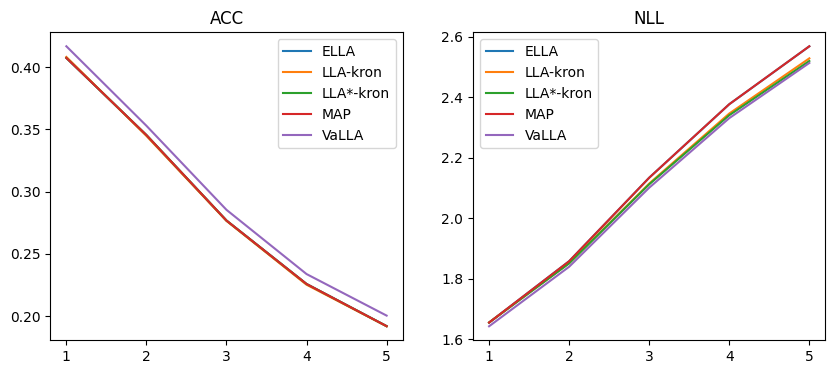

In [316]:
fig, axis = plt.subplots(1, 2, figsize=(10, 4))
plot_corruptions("CIFAR10", "ACC", range(1,6), axis[0])
plot_corruptions("CIFAR10", "NLL", range(1,6), axis[1])
plt.show()


In [317]:
subset =  [("ACC", "mean"), ("ACC MC", "mean"),
           ("NLL", "mean"), ("NLL MC", "mean"),
           ("ECE", "mean"), ("ECE MC", "mean"),
            ("BRIER MC", "mean"), ("BRIER", "mean"), 
            ("OOD-AUC", "mean"), ("OOD-AUC MC", "mean"),
            ("time", "mean")]
multiclass.query("dataset == 'CIFAR10'")[subset].reset_index().style.background_gradient(axis=0, subset = subset) 

,dataset,model,M,subset,hessian,alpha,ACC,ACC MC,NLL,NLL MC,ECE,ECE MC,BRIER MC,BRIER,OOD-AUC,OOD-AUC MC,time
,,,,,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,CIFAR10,ELLA,2000.000000,nan,nan,nan,0.422700,0.422900,1.618672,1.618698,0.020973,0.020936,0.712400,0.712391,0.591225,0.591224,3241.702234
1,CIFAR10,LLA,nan,all,diag,nan,0.423500,0.400500,1.625071,1.669111,0.050848,0.021221,0.727789,0.713737,0.548394,0.587526,311.685084
2,CIFAR10,LLA,nan,all,kron,nan,0.423400,0.416900,1.615519,1.626728,0.013934,0.008771,0.715370,0.711017,0.559162,0.573247,343.292758
3,CIFAR10,LLA,nan,last_layer,diag,nan,0.422600,0.424100,1.618577,1.617980,0.019520,0.018426,0.712100,0.712463,0.590034,0.590127,27.643092
4,CIFAR10,LLA,nan,last_layer,full,nan,0.422800,0.406300,1.616997,1.649490,0.010830,0.023318,0.722473,0.711773,0.583495,0.597356,14090.843479
5,CIFAR10,LLA,nan,last_layer,kron,nan,0.422700,0.406600,1.617041,1.649272,0.011367,0.023264,0.722275,0.711803,0.583778,0.597140,39.491983
6,CIFAR10,MAP,nan,nan,nan,nan,0.422700,0.422700,1.618684,1.618684,0.020948,0.020882,0.712396,0.712396,0.591253,0.591239,0.000000
7,CIFAR10,VaLLA,50.000000,nan,nan,1.000000,0.431480,0.414820,1.605603,1.631687,0.014202,0.012755,0.716638,0.705639,0.575757,0.585370,2406.951716
8,CIFAR10,VaLLA,100.000000,nan,nan,1.000000,0.432420,0.414100,1.603884,1.633306,0.016482,0.014114,0.717216,0.704727,0.574525,0.585071,3144.665786


#### FMNIST

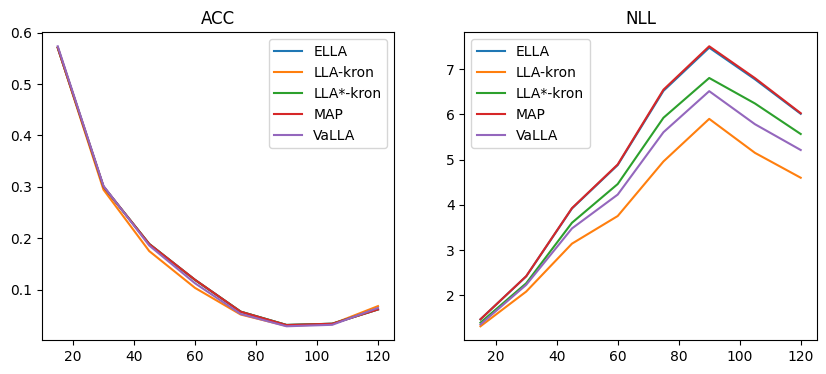

In [318]:
fig, axis = plt.subplots(1, 2, figsize=(10, 4))
plot_corruptions("FMNIST", "ACC", range(15,135, 15), axis[0])
plot_corruptions("FMNIST", "NLL", range(15, 135, 15), axis[1])
plt.show()


In [319]:
multiclass.query("dataset == 'FMNIST'")[subset].reset_index().style.background_gradient(axis=0, subset = subset) 

,dataset,model,M,subset,hessian,alpha,ACC,ACC MC,NLL,NLL MC,ECE,ECE MC,BRIER MC,BRIER,OOD-AUC,OOD-AUC MC,time
,,,,,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,FMNIST,ELLA,2000.000000,nan,nan,nan,0.878500,0.878640,0.349374,0.349324,0.010937,0.010874,0.178946,0.178983,0.852779,0.852836,404.715624
1,FMNIST,LLA,nan,all,diag,nan,0.869700,0.877400,0.377449,0.381917,0.037737,0.067026,0.188992,0.190310,0.897881,0.880038,239.342524
2,FMNIST,LLA,nan,all,kron,nan,0.875600,0.878500,0.354766,0.351578,0.015108,0.021936,0.179622,0.181584,0.932904,0.932211,236.247388
3,FMNIST,LLA,nan,last_layer,diag,nan,0.877900,0.878700,0.350333,0.349064,0.010729,0.009799,0.178777,0.179482,0.858916,0.855617,25.153209
4,FMNIST,LLA,nan,last_layer,full,nan,0.878600,0.878600,0.349880,0.359264,0.014982,0.018560,0.182121,0.178877,0.854522,0.856427,16947.627448
5,FMNIST,LLA,nan,last_layer,kron,nan,0.878500,0.878700,0.349457,0.357878,0.013552,0.016283,0.181563,0.178847,0.854361,0.855798,33.394295
6,FMNIST,MAP,nan,nan,nan,nan,0.878600,0.878600,0.349378,0.349378,0.010910,0.010910,0.178955,0.178955,0.852874,0.852888,0.000000
7,FMNIST,VaLLA,50.000000,nan,nan,1.000000,0.881900,0.878700,0.340080,0.350542,0.011212,0.014404,0.179379,0.174572,0.879841,0.872594,2209.075073
8,FMNIST,VaLLA,100.000000,nan,nan,1.000000,0.882880,0.878820,0.338198,0.351411,0.011063,0.016300,0.179603,0.173638,0.885849,0.877544,2803.302290


#### MNIST

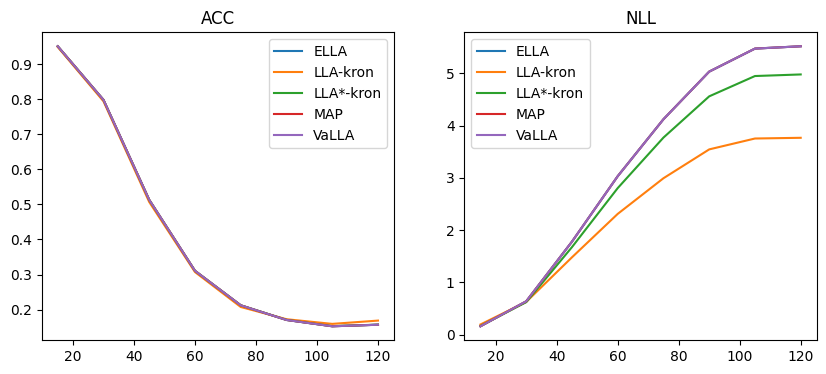

In [326]:
fig, axis = plt.subplots(1, 2, figsize=(10, 4))
plot_corruptions("MNIST", "ACC", range(15, 135, 15), axis[0])
plot_corruptions("MNIST", "NLL", range(15, 135, 15), axis[1])
plt.show()


In [321]:
multiclass.query("dataset == 'MNIST'")[subset].reset_index().style.background_gradient(axis=0, subset = subset) 

,dataset,model,M,subset,hessian,alpha,ACC,ACC MC,NLL,NLL MC,ECE,ECE MC,BRIER MC,BRIER,OOD-AUC,OOD-AUC MC,time
,,,,,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,MNIST,ELLA,2000.000000,nan,nan,nan,0.979100,0.979100,0.070500,0.070500,0.009068,0.009068,0.033669,0.033669,0.957311,0.957315,386.373027
1,MNIST,LLA,nan,all,diag,nan,0.978299,0.977800,0.138061,0.156423,0.074623,0.092531,0.055694,0.049834,0.973378,0.973446,247.230593
2,MNIST,LLA,nan,all,kron,nan,0.979200,0.978999,0.091611,0.097584,0.033304,0.041073,0.040265,0.038180,0.982985,0.983005,298.348522
3,MNIST,LLA,nan,last_layer,diag,nan,0.978600,0.979000,0.073549,0.073962,0.013139,0.014592,0.034330,0.034017,0.957656,0.958441,37.925711
4,MNIST,LLA,nan,last_layer,full,nan,0.979000,0.979000,0.076547,0.077708,0.017226,0.017223,0.034876,0.034445,0.958703,0.957088,17535.286468
5,MNIST,LLA,nan,last_layer,kron,nan,0.979000,0.978900,0.076085,0.076662,0.016663,0.015689,0.034697,0.034393,0.958546,0.958211,42.690148
6,MNIST,MAP,nan,nan,nan,nan,0.979100,0.979100,0.070500,0.070500,0.009068,0.009068,0.033669,0.033669,0.957311,0.957315,0.000000
7,MNIST,VaLLA,50.000000,nan,nan,1.000000,0.979100,0.979100,0.070500,0.070500,0.009068,0.009068,0.033669,0.033669,0.957311,0.957315,9948.386115
8,MNIST,VaLLA,100.000000,nan,nan,1.000000,0.979100,0.979100,0.070500,0.070500,0.009068,0.009068,0.033669,0.033669,0.957311,0.957315,10770.952922


# Classification Convolutional LeNet-5 (Trainable prior)

In [ ]:

res1 = [i for i in glob.glob("results/MAP_Conv_dataset=F*[!fixed_prior]")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
map =pd.concat(df)

ValueError: No objects to concatenate

In [ ]:

res1 = [i for i in glob.glob("results/LLA_Conv_dataset*[!fixed_prior]")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
lla = pd.concat(df)

ValueError: No objects to concatenate

In [ ]:

res1 = [i for i in glob.glob("results/VaLLA_Conv_dataset*[!fixed_prior]")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
valla = pd.concat(df)


ValueError: No objects to concatenate

In [ ]:

valla["model"] = "VaLLA"
valla["time"] = valla["timer"]
valla = valla.drop("timer", axis = 1)
map["model"] = "MAP"
lla["model"] = "LLA"
df = pd.concat([map, lla, valla]).drop(
    ["LOSS", "Unnamed: 0", "iterations", "weight_decay", "MAP_iterations"], axis=1
)
multiclass = df.groupby(["model", "M", "subset", "hessian"], dropna=False).agg(["mean", std])
multiclass = multiclass.drop(["seed", "alpha","prior_std"], axis = 1)
multiclass = multiclass.dropna(axis = 1, how = 'all')
multiclass

NameError: name 'valla' is not defined